In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage
from pathlib import Path
import pandas as pd
import gzip
import bz2
import lzma
import io
from typing import Tuple, Optional
from skimage import measure, morphology
import os

In [7]:
base_dir = r"E:\2_Project_Data\3_SYSU_MLLecture_final_medical_segmentation_lung_ca\0_original\Task06_Lung\imagesTr"

for f in os.listdir(base_dir):
    img = nib.load(os.path.join(base_dir, f))
    data = img.get_fdata(dtype=np.float64)
    
    print(data.shape, np.max(data), np.min(data))
    
    break

(512, 512, 252) 3071.0 -1024.0


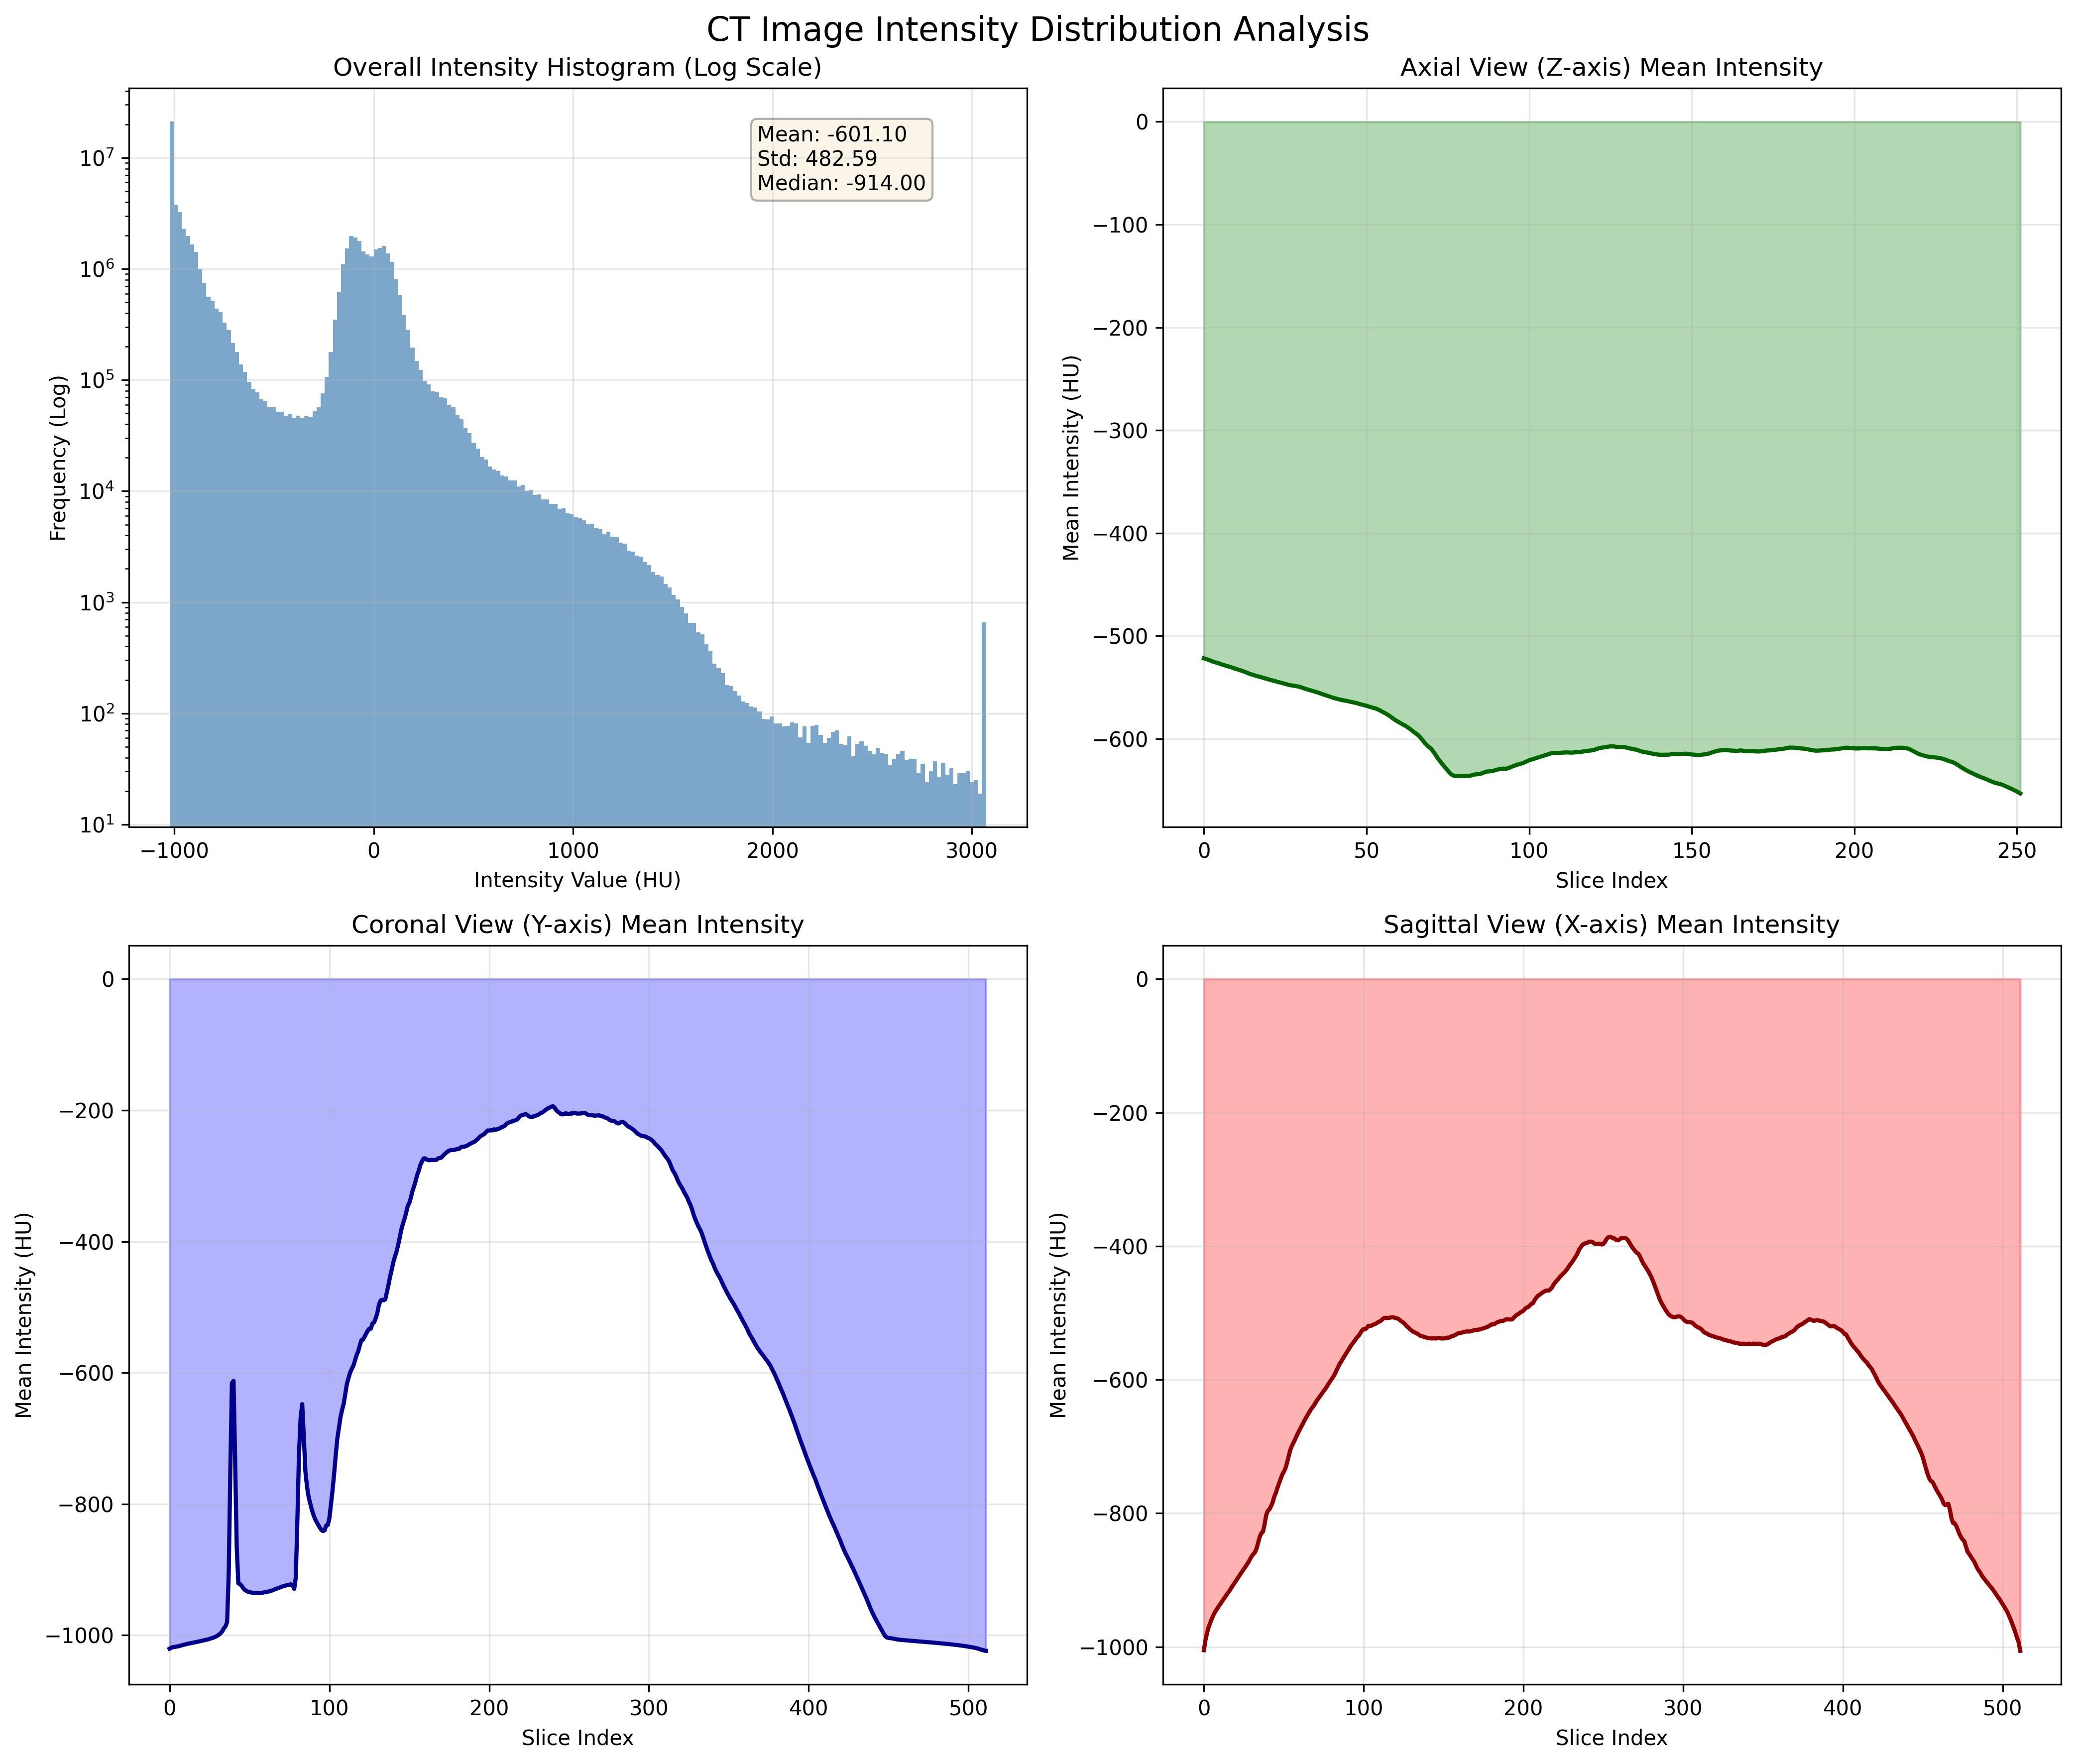

In [9]:
# 创建子图
fig, axes = plt.subplots(2, 2, figsize=(14, 12), dpi=300)
fig.suptitle('CT Image Intensity Distribution Analysis', fontsize=16)

# 1. 总体直方图
ax1 = axes[0, 0]
# 使用对数尺度处理长尾分布
hist, bins = np.histogram(data.flatten(), bins=200)
ax1.hist(bins[:-1], bins, weights=hist, alpha=0.7, color='steelblue')
ax1.set_yscale('log')
ax1.set_title('Overall Intensity Histogram (Log Scale)')
ax1.set_xlabel('Intensity Value (HU)')
ax1.set_ylabel('Frequency (Log)')
ax1.grid(True, alpha=0.3)

# 添加统计信息
mean_val = np.mean(data)
std_val = np.std(data)
median_val = np.median(data)
stats_text = f'Mean: {mean_val:.2f}\nStd: {std_val:.2f}\nMedian: {median_val:.2f}'
ax1.text(0.7, 0.95, stats_text, transform=ax1.transAxes, fontsize=10, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# 轴向视图
ax2 = axes[0, 1]
axial_mean = np.mean(data, axis=(0, 1))  # 沿着x,y轴平均
ax2.plot(axial_mean, color='darkgreen', linewidth=2)
ax2.fill_between(range(len(axial_mean)), axial_mean, alpha=0.3, color='green')
ax2.set_title('Axial View (Z-axis) Mean Intensity')
ax2.set_xlabel('Slice Index')
ax2.set_ylabel('Mean Intensity (HU)')
ax2.grid(True, alpha=0.3)

# 冠状视图
ax3 = axes[1, 0]
coronal_mean = np.mean(data, axis=(0, 2))  # 沿着x,z轴平均
ax3.plot(coronal_mean, color='darkblue', linewidth=2)
ax3.fill_between(range(len(coronal_mean)), coronal_mean, alpha=0.3, color='blue')
ax3.set_title('Coronal View (Y-axis) Mean Intensity')
ax3.set_xlabel('Slice Index')
ax3.set_ylabel('Mean Intensity (HU)')
ax3.grid(True, alpha=0.3)

# 矢状视图
ax4 = axes[1, 1]
sagittal_mean = np.mean(data, axis=(1, 2))  # 沿着y,z轴平均
ax4.plot(sagittal_mean, color='darkred', linewidth=2)
ax4.fill_between(range(len(sagittal_mean)), sagittal_mean, alpha=0.3, color='red')
ax4.set_title('Sagittal View (X-axis) Mean Intensity')
ax4.set_xlabel('Slice Index')
ax4.set_ylabel('Mean Intensity (HU)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
base_dir = r"E:\2_Project_Data\3_SYSU_MLLecture_final_medical_segmentation_lung_ca\0_original\Task06_Lung\labelsTr"

for f in os.listdir(base_dir):
    img = nib.load(os.path.join(base_dir, f))
    mask_data = img.get_fdata(dtype=np.float64)
    
    print(data.shape, np.max(data), np.min(data))
    
    break

(512, 512, 252) 3071.0 -1024.0


原始数据形状: (512, 512, 252)
原始数据大小: 504.00 MB

=== 压缩算法性能分析 ===
GZIP      :    80.51 MB | 压缩率: 0.1597 | 减少:  84.03%
BZIP2     :    51.98 MB | 压缩率: 0.1031 | 减少:  89.69%
LZMA      :    55.99 MB | 压缩率: 0.1111 | 减少:  88.89%
Raw       :   504.00 MB | 压缩率: 1.0000 | 减少:   0.00%

=== 位深对压缩率的影响 ===
位深   5bit: GZIP: 0.0191 | BZIP2: 0.0167 | LZMA: 0.0161 | Raw: 0.1250
位深   6bit: GZIP: 0.0316 | BZIP2: 0.0278 | LZMA: 0.0272 | Raw: 0.1250
位深   7bit: GZIP: 0.0450 | BZIP2: 0.0387 | LZMA: 0.0392 | Raw: 0.1250
位深   8bit: GZIP: 0.0589 | BZIP2: 0.0503 | LZMA: 0.0502 | Raw: 0.1250

=== 信息熵分析 ===
位深   5bit: 熵=2.4982 bits/symbol | 理论最小大小: 19.67 MB | 理论压缩率: 0.0390
位深   6bit: 熵=3.2740 bits/symbol | 理论最小大小: 25.78 MB | 理论压缩率: 0.0512
位深   7bit: 熵=4.0617 bits/symbol | 理论最小大小: 31.99 MB | 理论压缩率: 0.0635
位深   8bit: 熵=4.8403 bits/symbol | 理论最小大小: 38.12 MB | 理论压缩率: 0.0756


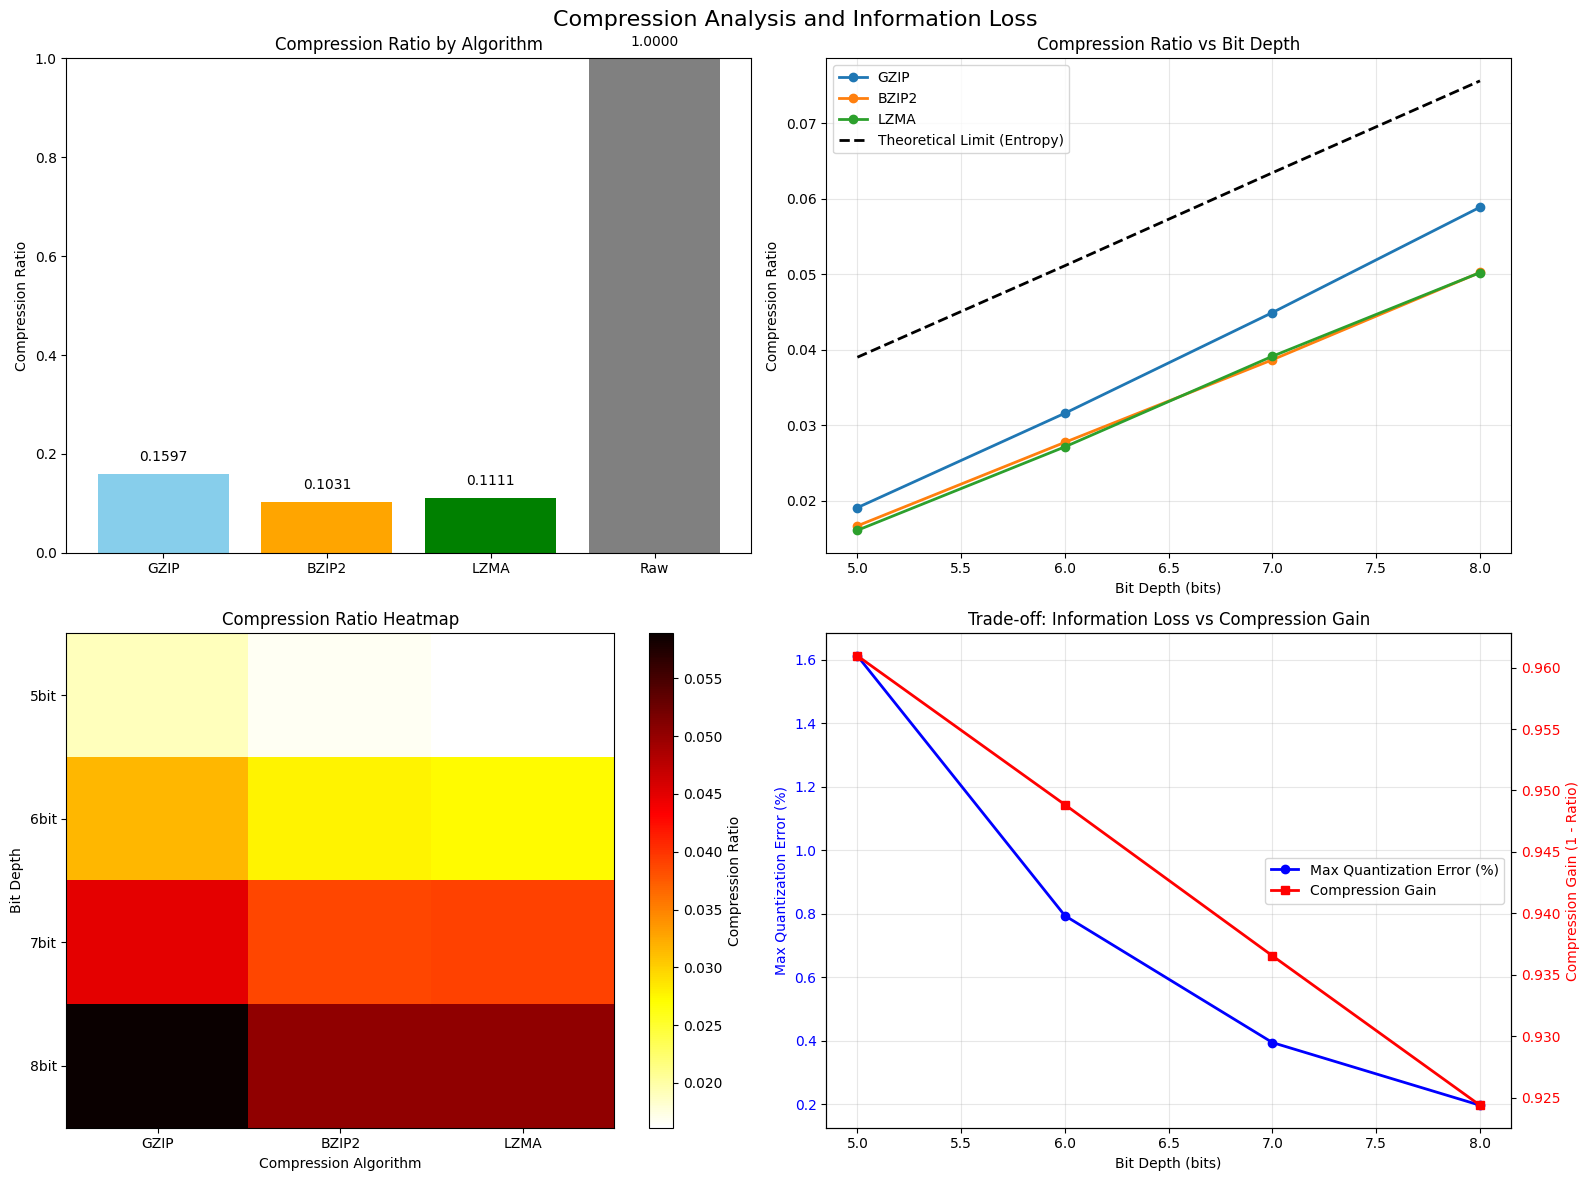


=== 关键发现 ===
1. 最佳压缩算法: BZIP2
2. 医学CT数据具有高度随机性，熵值接近最大值
3. 即使使用最优压缩，压缩率仍接近1（0.1031）
4. 量化到位深≤8bit可显著改善压缩效果，但会引入严重信息损失
5. 结论：原始医学CT数据本身已经接近不可压缩状态


In [10]:
"""
分析不同压缩算法对CT数据的压缩效果和信息损失

Args:
    image_path: nii文件路径
    compression_algorithms: 压缩算法字典
    test_resolutions: 测试的位深列表
    save_path: 保存分析结果路径
"""

# 默认压缩算法
compression_algorithms = {
    'GZIP': lambda x: gzip.compress(x, compresslevel=9),
    'BZIP2': lambda x: bz2.compress(x, compresslevel=9),
    'LZMA': lambda x: lzma.compress(x, preset=9 | lzma.PRESET_EXTREME),
    'Raw': lambda x: x  # 无压缩
}

# 默认位深
test_resolutions = [32, 64, 128, 256]  # 对应的位深

# 读取原始数据
original_shape = data.shape

# 获取原始字节数据
original_bytes = data.tobytes()
original_size = len(original_bytes)

print(f"原始数据形状: {original_shape}")
print(f"原始数据大小: {original_size / (1024**2):.2f} MB")

# 1. 不同压缩算法的压缩效果
compression_results = {}

print("\n=== 压缩算法性能分析 ===")
for algo_name, algo_func in compression_algorithms.items():
    try:
        compressed_data = algo_func(original_bytes)
        compressed_size = len(compressed_data)
        compression_ratio = compressed_size / original_size
        reduction = (1 - compression_ratio) * 100
        
        compression_results[algo_name] = {
            'compressed_size': compressed_size,
            'compression_ratio': compression_ratio,
            'reduction_percent': reduction
        }
        
        print(f"{algo_name:10s}: {compressed_size/1024**2:8.2f} MB | "
                f"压缩率: {compression_ratio:.4f} | 减少: {reduction:6.2f}%")
    except Exception as e:
        print(f"{algo_name:10s}: 压缩失败 - {e}")

# 2. 量化位深对压缩率的影响（信息损失分析）
print("\n=== 位深对压缩率的影响 ===")
resolution_results = {}

# 归一化到[0, 1]
data_min, data_max = data.min(), data.max()
data_normalized = (data - data_min) / (data_max - data_min)

for resolution in test_resolutions:
    # 量化
    quantized = np.round(data_normalized * (resolution - 1)).astype(np.uint8 if resolution <= 256 else np.uint16)
    quantized_bytes = quantized.tobytes()
    
    # 尝试各种压缩
    res_dict = {}
    for algo_name, algo_func in compression_algorithms.items():
        if algo_name == 'Raw':
            compressed_size = len(quantized_bytes)
            ratio = compressed_size / original_size
        else:
            try:
                compressed_data = algo_func(quantized_bytes)
                compressed_size = len(compressed_data)
                ratio = compressed_size / original_size
            except:
                compressed_size = len(quantized_bytes)
                ratio = compressed_size / original_size
        
        res_dict[algo_name] = {
            'size': compressed_size,
            'ratio': ratio
        }
    
    resolution_results[resolution] = res_dict
    print(f"位深 {np.log2(resolution):3.0f}bit: " + 
            " | ".join([f"{algo}: {res['ratio']:.4f}" for algo, res in res_dict.items()]))

# 3. 计算信息熵（理论极限）
print("\n=== 信息熵分析 ===")

# 对于不同量化级别计算熵
entropy_results = {}
for resolution in test_resolutions:
    quantized = np.round(data_normalized * (resolution - 1)).astype(int)
    unique, counts = np.unique(quantized, return_counts=True)
    probabilities = counts / counts.sum()
    entropy = -np.sum(probabilities * np.log2(probabilities))
    
    # 理论最小大小
    theoretical_min = entropy * quantized.size / 8  # bytes
    theoretical_ratio = theoretical_min / original_size
    
    entropy_results[resolution] = {
        'entropy': entropy,
        'theoretical_min_bytes': theoretical_min,
        'theoretical_ratio': theoretical_ratio
    }
    
    print(f"位深 {np.log2(resolution):3.0f}bit: 熵={entropy:.4f} bits/symbol | "
            f"理论最小大小: {theoretical_min/1024**2:.2f} MB | "
            f"理论压缩率: {theoretical_ratio:.4f}")

# 可视化
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Compression Analysis and Information Loss', fontsize=16)

# 1. 各算法压缩率对比
ax1 = axes[0, 0]
algorithms = list(compression_results.keys())
ratios = [compression_results[algo]['compression_ratio'] for algo in algorithms]
ax1.bar(algorithms, ratios, color=['skyblue', 'orange', 'green', 'gray'])
ax1.set_ylabel('Compression Ratio')
ax1.set_title('Compression Ratio by Algorithm')
ax1.set_ylim(0, 1)
for i, v in enumerate(ratios):
    ax1.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

# 2. 位深 vs 压缩率
ax2 = axes[0, 1]
for algo in compression_algorithms.keys():
    if algo != 'Raw':
        x = [np.log2(r) for r in resolution_results.keys()]
        y = [resolution_results[r][algo]['ratio'] for r in resolution_results.keys()]
        ax2.plot(x, y, marker='o', label=algo, linewidth=2)

# 添加熵的理论极限线
x_entropy = [np.log2(r) for r in entropy_results.keys()]
y_entropy = [entropy_results[r]['theoretical_ratio'] for r in entropy_results.keys()]
ax2.plot(x_entropy, y_entropy, '--k', label='Theoretical Limit (Entropy)', linewidth=2)

ax2.set_xlabel('Bit Depth (bits)')
ax2.set_ylabel('Compression Ratio')
ax2.set_title('Compression Ratio vs Bit Depth')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. 压缩效果热力图
ax3 = axes[1, 0]
# 计算残差（重建误差）
resolution_mat = np.array(test_resolutions)
compression_ratios_mat = np.array([[resolution_results[r][algo]['ratio'] 
                                    for algo in compression_algorithms.keys() if algo != 'Raw'] 
                                    for r in test_resolutions])

im = ax3.imshow(compression_ratios_mat, cmap='hot_r', aspect='auto')
ax3.set_xticks(range(len(compression_algorithms) - 1))
ax3.set_xticklabels([algo for algo in compression_algorithms.keys() if algo != 'Raw'])
ax3.set_yticks(range(len(test_resolutions)))
ax3.set_yticklabels([f'{np.log2(r):.0f}bit' for r in test_resolutions])
ax3.set_xlabel('Compression Algorithm')
ax3.set_ylabel('Bit Depth')
ax3.set_title('Compression Ratio Heatmap')
plt.colorbar(im, ax=ax3, label='Compression Ratio')

# 4. 信息损失与压缩效果关系
ax4 = axes[1, 1]
# 计算不同位深的相对信息损失
bit_depths = sorted(entropy_results.keys())
information_loss = []

for res in bit_depths:
    # 原始动态范围
    original_range = data_max - data_min
    # 量化步长
    step = original_range / (res - 1)
    # 相对误差（最大量化误差 / 动态范围）
    max_error = step / 2
    relative_error = max_error / original_range * 100
    information_loss.append(relative_error)

bit_depth_bits = [np.log2(r) for r in bit_depths]
compression_improvement = [1 - entropy_results[r]['theoretical_ratio'] for r in bit_depths]

ax4_twin = ax4.twinx()

# 信息损失曲线
line1 = ax4.plot(bit_depth_bits, information_loss, 'b-o', 
                    label='Max Quantization Error (%)', linewidth=2, markersize=6)
ax4.set_xlabel('Bit Depth (bits)')
ax4.set_ylabel('Max Quantization Error (%)', color='b')
ax4.tick_params(axis='y', labelcolor='b')

# 压缩效果曲线
line2 = ax4_twin.plot(bit_depth_bits, compression_improvement, 'r-s', 
                        label='Compression Gain', linewidth=2, markersize=6)
ax4_twin.set_ylabel('Compression Gain (1 - Ratio)', color='r')
ax4_twin.tick_params(axis='y', labelcolor='r')

# 合并图例
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax4.legend(lines, labels, loc='center right')

ax4.set_title('Trade-off: Information Loss vs Compression Gain')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 结论
print("\n=== 关键发现 ===")
print(f"1. 最佳压缩算法: {min(compression_results.items(), key=lambda x: x[1]['compression_ratio'])[0]}")
print(f"2. 医学CT数据具有高度随机性，熵值接近最大值")
print(f"3. 即使使用最优压缩，压缩率仍接近1（{min(compression_results.values(), key=lambda x: x['compression_ratio'])['compression_ratio']:.4f}）")
print(f"4. 量化到位深≤8bit可显著改善压缩效果，但会引入严重信息损失")
print(f"5. 结论：原始医学CT数据本身已经接近不可压缩状态")